# Harmonic Networks ($\mathrm{SO}(2)$-CNNs)

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

if not any('GPU' in device for device in tf.config.list_physical_devices()):
    print('[WARNING] No GPU available!')

import numpy as np

import sys, os
sys.path.append('..')

from data import visualization, loader, utils

from networks.h_net.layers import *

## Hyperparameters

In [10]:
# Learning
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 128

LEARNING_RATE = 0.00535
DECAY_RATE = 0.7594
LR_SCHEDULE = keras.optimizers.schedules.ExponentialDecay(
    LEARNING_RATE,
    decay_steps=10000//BATCH_SIZE,
    decay_rate=DECAY_RATE,
    staircase=True)

OPTIMIZER = keras.optimizers.Adam(learning_rate=LR_SCHEDULE)
LOSS = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Initializer
PROFILE_INITIALIZER = 'he_normal'
PHASE_INITIALIZER = tf.keras.initializers.RandomUniform(0, 2*np.pi)
BIAS_INITIALIZER = 'zero'

# Regularization
PROFILE_REGULARIZER = tf.keras.regularizers.L2(0.05014)
DROP_RATE = 0.0287

# Harmonic kernels
LEARN_PHASE_OFFSET = True
CONJUGATE_WEIGHTS = True
N_RINGS = 4

CONV__HYPERPARAMS = {'phase': LEARN_PHASE_OFFSET, 
                     'profile_initializer': PROFILE_INITIALIZER, 
                     'phase_initializer': PHASE_INITIALIZER, 
                     'profile_regularizer': PROFILE_REGULARIZER, 
                     'n_rings': N_RINGS, 
                     'conjugate_weights': CONJUGATE_WEIGHTS}

ACTIVATION = tf.keras.activations.relu


## Data Preparation

In [11]:
# as numpy arrays
train_np, valid_np, test_np = loader.mnist_rot_np()
train_x, train_y = train_np['x'], train_np['y']
valid_x, valid_y = valid_np['x'], valid_np['y']
test_x, test_y = test_np['x'], test_np['y']

# tensorflow datasets
train_dataset, valid_dataset, test_dataset = loader.mnist_rot_tf(BATCH_SIZE, SHUFFLE_BUFFER_SIZE, drop_remainder=True, normalize=True)

## Model Definition

In [12]:
model = tf.keras.Sequential(
        [
            layers.InputLayer(shape=(784,), batch_size=BATCH_SIZE),
            layers.Reshape((28, 28, 1)),
            
            # data augmentation
            keras.layers.RandomRotation(factor=1, fill_mode='constant', value_range=(0,1), name='DataAugmentation'),
            layers.Reshape((28, 28, 1, 1, 1)),
            
            # layer 1
            HRangeConv(channels=8, ksize=5, padding='SAME', in_range=(0,0), out_range=(0,1), name='HConv1', **CONV__HYPERPARAMS),
            HBatchNorm(nonlin=ACTIVATION, name='HBatchNorm1'),
            
            # layer 2
            HDropout(rate=DROP_RATE),
            HRangeConv(channels=8, ksize=5, padding='SAME', in_range=(0,1), out_range=(0,1), name='HConv2', **CONV__HYPERPARAMS),
            HBatchNorm(nonlin=ACTIVATION, name='HBatchNorm2'),
            
            MeanPool(ksize=(2,2), strides=(2,2), name='MeanPool1'),
            
            # layer 3
            HDropout(rate=DROP_RATE),
            HRangeConv(channels=16, ksize=5, padding='SAME', in_range=(0,1), out_range=(0,1), name='HConv3', **CONV__HYPERPARAMS),
            HBatchNorm(nonlin=ACTIVATION, name='HBatchNorm3'),
            
            # layer 4
            HDropout(rate=DROP_RATE),
            HRangeConv(channels=16, ksize=5, padding='SAME', in_range=(0,1), out_range=(0,1), name='HConv4', **CONV__HYPERPARAMS),
            HBatchNorm(nonlin=ACTIVATION, name='HBatchNorm4'),
            
            # layer 5
            HDropout(rate=DROP_RATE),
            HRangeConv(channels=34, ksize=5, padding='SAME', in_range=(0,1), out_range=(0,1), name='HConv5', **CONV__HYPERPARAMS),
            HBatchNorm(nonlin=ACTIVATION, name='HBatchNorm5'),
            
            MeanPool(ksize=(2,2), strides=(2,2), name='MeanPool5'),
            
            # layer 6
            HDropout(rate=DROP_RATE),
            HRangeConv(channels=34, ksize=5, padding='SAME', in_range=(0,1), out_range=(0,1), name='HConv6', **CONV__HYPERPARAMS),
            HBatchNorm(nonlin=ACTIVATION, name='HBatchNorm6'),
            
            # layer 7
            HDropout(rate=DROP_RATE),
            HRangeConv(channels=10, ksize=5, padding='SAME', in_range=(0,1), out_range=(0,0), name='HConv7', **CONV__HYPERPARAMS),
                   
            Magnitudes(add_bias=True, keepdims=False, eps=1e-4),
            Reduce(fn=tf.reduce_mean, keepdims=False)
        ]
    )


model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_2 (Reshape)             │ (32, 28, 28, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ DataAugmentation                │ (32, 28, 28, 1)        │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (32, 28, 28, 1, 1, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HConv1 (HRangeConv)             │ (32, 28, 28, 2, 2, 8)  │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HBatchNorm1 (HBatchNorm)        │ (32, 28, 28, 2, 2, 8)  │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h_dropout_6 (HDropout)          │ (32, 28, 28, 2, 2, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HConv2 (HRangeConv)             │ (32, 28, 28, 2, 2, 8)  │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HBatchNorm2 (HBatchNorm)        │ (32, 28, 28, 2, 2, 8)  │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MeanPool1 (MeanPool)            │ (32, 14, 14, 2, 2, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h_dropout_7 (HDropout)          │ (32, 14, 14, 2, 2, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HConv3 (HRangeConv)             │ (32, 14, 14, 2, 2, 16) │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HBatchNorm3 (HBatchNorm)        │ (32, 14, 14, 2, 2, 16) │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h_dropout_8 (HDropout)          │ (32, 14, 14, 2, 2, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HConv4 (HRangeConv)             │ (32, 14, 14, 2, 2, 16) │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HBatchNorm4 (HBatchNorm)        │ (32, 14, 14, 2, 2, 16) │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h_dropout_9 (HDropout)          │ (32, 14, 14, 2, 2, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HConv5 (HRangeConv)             │ (32, 14, 14, 2, 2, 34) │         5,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HBatchNorm5 (HBatchNorm)        │ (32, 14, 14, 2, 2, 34) │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MeanPool5 (MeanPool)            │ (32, 7, 7, 2, 2, 34)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h_dropout_10 (HDropout)         │ (32, 7, 7, 2, 2, 34)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HConv6 (HRangeConv)             │ (32, 7, 7, 2, 2, 34)   │        11,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HBatchNorm6 (HBatchNorm)        │ (32, 7, 7, 2, 2, 34)   │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h_dropout_11 (HDropout)         │ (32, 7, 7, 2, 2, 34)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HConv7 (HRangeConv)             │ (32, 7, 7, 1, 2, 10)   │         3,400 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 25,434 (99.35 KB)

 Trainable params: 25,202 (98.45 KB)

 Non-trainable params: 232 (928.00 B)

## Training
A trained model can be loaded below

Epoch 1/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.2144 - loss: 33.5091 - val_accuracy: 0.1966 - val_loss: 13.3419
Epoch 2/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.3521 - loss: 11.6378 - val_accuracy: 0.2812 - val_loss: 6.7675
Epoch 3/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5787 - loss: 5.8242 - val_accuracy: 0.5968 - val_loss: 4.2014
Epoch 4/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.7842 - loss: 3.3032 - val_accuracy: 0.5600 - val_loss: 3.4177
Epoch 5/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.8357 - loss: 2.3189 - val_accuracy: 0.6305 - val_loss: 2.9730
Epoch 6/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.8617 - loss: 1.7647 - val_accuracy: 0.7686 - val_loss: 1.7991
Epoch 7/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.8836 - loss: 1.4156 - val_accuracy: 0.7833 - val_loss: 1.6112
Epoch 8/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.8914 - loss: 1.2132 - val_

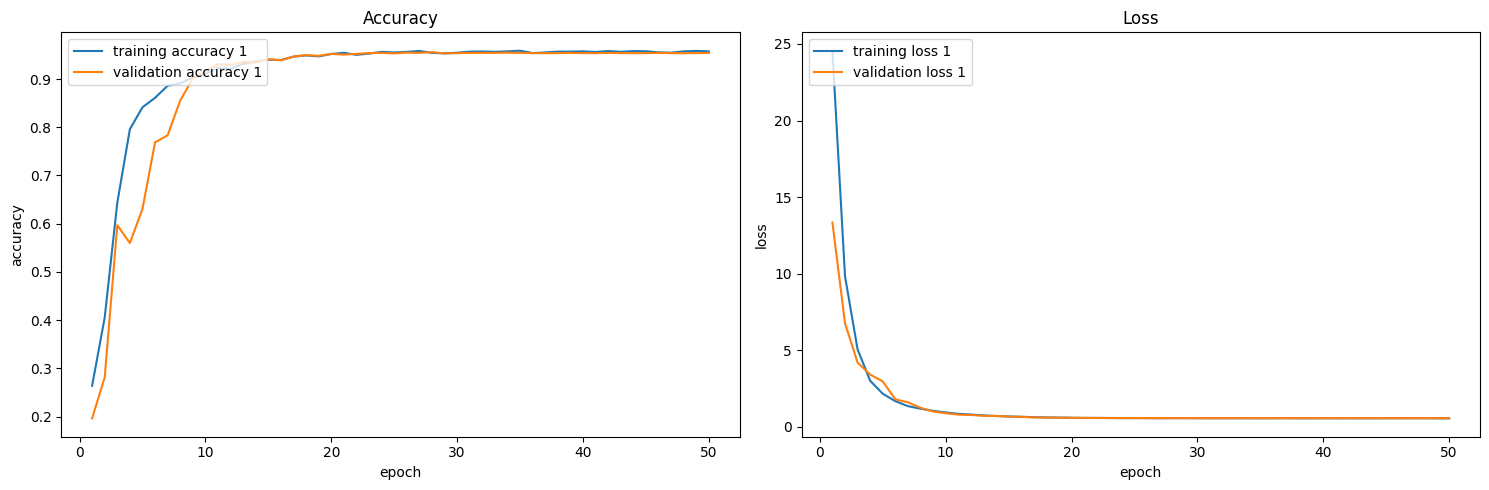

In [13]:
model.compile(
    loss=LOSS, 
    optimizer=OPTIMIZER,
    metrics=["accuracy"]
)

hist = model.fit(train_dataset, epochs=50, validation_data=valid_dataset)

visualization.training_history(hist)

## Loading trained model

In [14]:
model = keras.models.load_model(os.path.join('trained_models','h_net', '25000', 'training1.model.keras'))

## Evaluation

### Accuracy

In [15]:
loss, accuracy = model.evaluate(test_dataset)

print(f'{accuracy=:.4f}')
print(f'{loss=:.4f}')

1562/1562 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.9615 - loss: 0.5188
accuracy=0.9595
loss=0.5253


### Confusion Matrix

1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


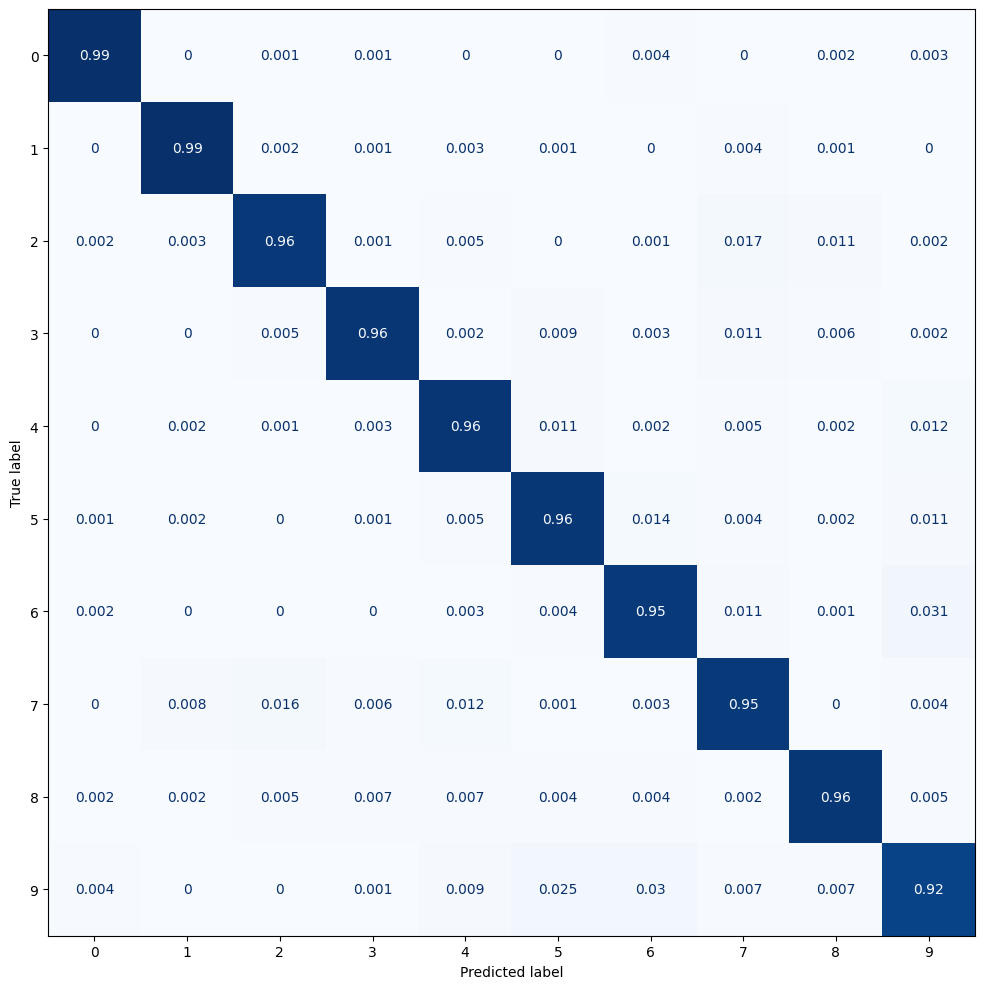

In [22]:
cm = utils.get_confusion_matrix(model, test_dataset, test_y[:-(10000%BATCH_SIZE)], class_names=list(range(10)))
visualization.confusion_matrix(cm, class_names=list(range(10)))

# Kernel Visualization

In [ ]:
from ipywidgets import interact, Dropdown

# prepare widgets
conv_layers = [(layer.name, layer) for layer in model.layers 
              if isinstance(layer, HRangeConv)]
layerW = Dropdown(options=conv_layers)
in_channelW = Dropdown(description='in channel')
out_channelW = Dropdown(description='out channel')

def update_options(*args):
    """Updates the channel widgets when the layer changes."""
    layer = layerW.value
    in_channelW.options = range(layer.input.shape[-1])
    out_channelW.options = range(layer.output.shape[-1])
    
    if in_channelW.value not in in_channelW.options:
        in_channelW.value = 0
    if out_channelW.value not in out_channelW.options:
        out_channelW.value = 0
    
layerW.observe(update_options)

@interact(layer=layerW, in_channel=in_channelW, out_channel=out_channelW)
def show_filters(layer, in_channel=0, out_channel=0):
    """Shows the filters of the conv layer for the given input and output channel."""
    filters = layer.get_grid_filters()
    filters = {m: f[0].numpy()+1j*f[1].numpy() for m, f in filters.items()}

    selected_filters = [filters[m][:,:,in_channel,out_channel] for m in filters]
    visualization.complex_image_grid(selected_filters, 
                                     [f'{m=}' for m in filters], one_row=True)

In [24]:
filters = model.get_layer(name='HConv1').get_grid_filters()
filters = {m: f[0].numpy()+1j*f[1].numpy() for m, f in filters.items()}

selected_filters = [filters[m][:,:,0,0] for m in filters]

## Feature Map Visualization

In [25]:
def layer_output(layer, inpt):
    """Computes the layer's output for the given model input."""
    layer_out = keras.Model(inputs=model.inputs, outputs=[layer.output])
    return layer_out(inpt[np.newaxis,:], training=False)[0].numpy()

def get_out_order_range(layer):
    prev_layers = model.layers[:model.layers.index(layer)+1]
    for l in reversed(prev_layers):
        if isinstance(l, Reduce):
            return ()
        if isinstance(l, HRangeConv):
            return range(l.out_range[0], l.out_range[1]+1)
    return range(1)

In [ ]:
from ipywidgets import interact, Dropdown, FloatSlider, BoundedIntText

# prepare widgets
layerW = Dropdown(options = [(layer.name, layer) for layer in model.layers])
channelW = Dropdown()
orderW = Dropdown()
imgW = BoundedIntText(min=0, max=len(test_x)-1, description='image nr')
rotW = FloatSlider(min=0, max=360, step=360/16, value=90, description='rotation')

def update_options(*args):
    """Updates the channel widgets when the layer changes."""
    layer = layerW.value
    channelW.options = range(layer.output.shape[-1])
    orderW.options = get_out_order_range(layer)
    
    if channelW.value not in channelW.options:
        channelW.value = 0
    if orderW.value not in orderW.options:
        if len(orderW.options)==0:
            orderW.value = None
        else:
            orderW.value = 0 if 0 in orderW.options else min(orderW.options)
        
layerW.observe(update_options)

@interact(layer=layerW, channel=channelW, order=orderW, img_nr=imgW, rot=rotW)
def show_layer_output(layer, channel=0, order=0, img_nr=0, rot=90):
    """Shows the layer's output for both an unrotated and rotated version of the image."""
    # prepare input
    img = test_x[img_nr]
    img_rot = utils.rotate_image(img, rot)
    
    # calculate layer output
    out = layer_output(layer, img)[...,channel] # shape=[h,w,orders,complex]
    out_rot = layer_output(layer, img_rot)[...,channel] # shape=[h,w,orders,complex]
    
     # unify dimensions
    if len(out.shape) == 2:
        # adding order and complex dimension: h,w -> h,w,orders,complex
        out = out[:,:,np.newaxis,np.newaxis]
        out_rot = out_rot[:,:,np.newaxis,np.newaxis]
    if len(out.shape) == 3:
        # adding complex dimension: h,w,orders -> h,w,orders,complex
        out = out[:,:,:,np.newaxis]
        out_rot = out_rot[:,:,:,np.newaxis]
    if len(out.shape) == 0:
        # adding spatial, order and complex dimensions: -> h,w,orders,complex
        out = out[..., np.newaxis, np.newaxis, np.newaxis, np.newaxis]
        out_rot = out_rot[..., np.newaxis, np.newaxis, np.newaxis, np.newaxis]

    if order==None: order=0
    out = out[:,:,order,:]
    out_rot = out_rot[:,:,order,:]

    if out.shape[2] == 2:
        vis_fn = visualization.complex_image_grid
        out = out[:,:,0] + 1j*out[:,:,1]
        out_rot = out_rot[:,:,0] + 1j*out_rot[:,:,1]
    else:
        vis_fn = visualization.image_grid
        out = out[:,:,0]
        out_rot = out_rot[:,:,0]

    out_rot_reversed = utils.rotate_image(out_rot, -rot)
        
    # show layer output
    vis_fn([out.round(10), out_rot.round(10), out_rot_reversed.round(10)], 
           ['original input', f'{rot:.2f}° rotated input', f'{rot:.2f}° rotated input (reversed rotation)'])

## Equivariance

In [ ]:
from ipywidgets import interact, FloatSlider, BoundedIntText

imgW = BoundedIntText(min=0, max=len(test_x)-1, description='image nr')
rotW = FloatSlider(min=0, max=360, step=360/16, value=90, description='input rotation')

@interact(img_nr=imgW, input_rot=rotW)
def show_equivariance(img_nr=0, input_rot=90):
    img = test_x[img_nr]
    print('digit:', test_y[img_nr])
    img_rot = utils.rotate_image(img, input_rot)

    out, out_rot = model(np.vstack([img, img_rot]), training=False)

    print('equal model output:', np.isclose(out, out_rot, rtol=1e-5, atol=1e-3).all())
    print('output distance:', np.linalg.norm(out-out_rot).round(3))

    visualization.image_grid([out[np.newaxis,:], out_rot[np.newaxis,:]], 
                            labels=['original input', '90° rotated input'], 
                            cols=1, figsize=(5,3))